In [1]:
import gym
from gym import envs
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from tqdm.notebook import tqdm as tqdm
from IPython.display import clear_output

In [2]:
gym.envs.registration.register(id="CartPole-v0",
    entry_point="gym.envs.classic_control:CartPoleEnv",
    max_episode_steps=2000,
    reward_threshold=195.0,)


C:\ProgramData\Anaconda3\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment CartPole-v0
  logger.warn("Overriding environment {}".format(id))


In [3]:
env = gym.make('CartPole-v0')
env.reset()

observations, reward, done, infos = env.step(1)
print(f' Observations: \n [ Cart Position: {observations[0]} | Cart Velocity: {observations[1]} |\n Pole Angle: {observations[2]} | Pole Angular Velocity: {observations[3]} ] \n Reward: {reward} \n Done: {done} \n Info: {infos}')

 Observations: 
 [ Cart Position: 0.032285772264003754 | Cart Velocity: 0.2228841930627823 |
 Pole Angle: 0.03315407410264015 | Pole Angular Velocity: -0.3105890452861786 ] 
 Reward: 1.0 
 Done: False 
 Info: {}


In [4]:
observations = observations.reshape(-1)
observations.shape

(4,)

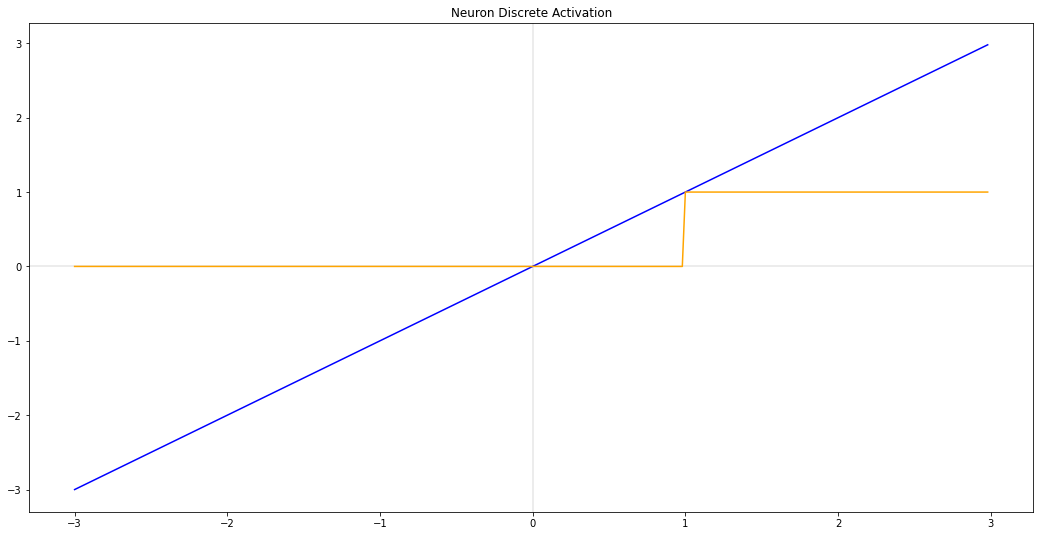

In [5]:
def activate(layer):
    return np.where(layer >= 1, 1, 0)

plt.figure(figsize=(18,9))
plt.axvline(0, color = 'gray', alpha = 0.2)
plt.axhline(0, color = 'gray', alpha = 0.2)
spolee = np.arange(-3, 3, 0.02)
activated = activate(spolee)
plt.plot(spolee, spolee, color = 'blue')
plt.plot(spolee, activated, color = 'orange')
plt.title('Neuron Discrete Activation');


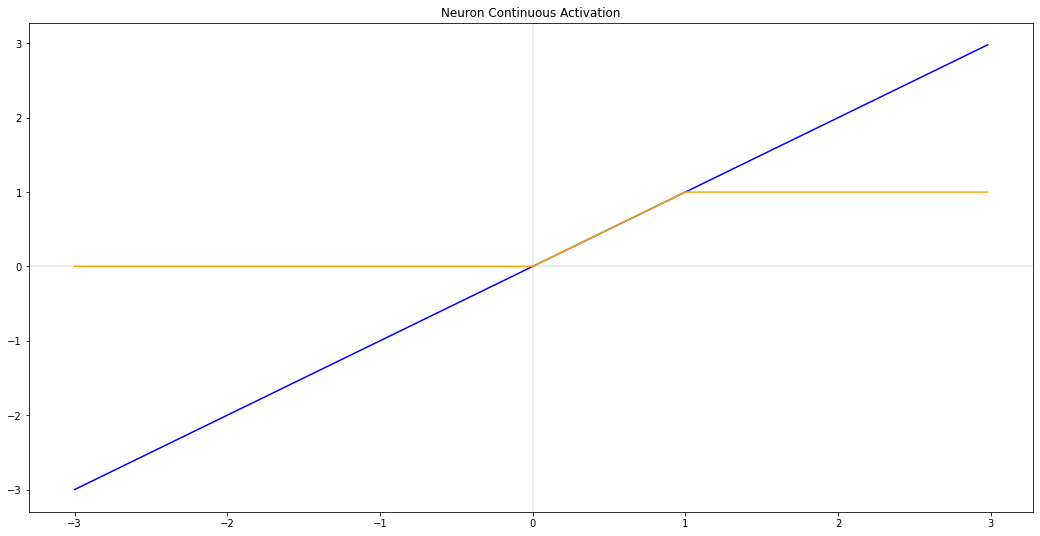

In [6]:
def continuous_activation(layer):
    return np.where(layer >= 1, 1, np.where(layer < 0, 0, spolee))

plt.figure(figsize=(18,9))
plt.axvline(0, color = 'gray', alpha = 0.2)
plt.axhline(0, color = 'gray', alpha = 0.2)
spolee = np.arange(-3, 3, 0.02)
activated = continuous_activation(spolee)
plt.plot(spolee, spolee, color = 'blue')
plt.plot(spolee, activated, color = 'orange')
plt.title('Neuron Continuous Activation');

In [7]:
def softmax_activate(layer):
    m = np.exp(layer)
    return m / m.sum()

def sigmoid_activate(layer):
    return 1 / (1 + np.exp(-layer))

In [8]:
nb_layers = 4
neurons = 25

In [9]:
percentage_saved = 0.1
chances_of_mutation = 1e-2

In [10]:
class NeuralNetwork:
    def __init__(self, observation_size, isACopy = False):
        self._rewards = 0
        self._layers = []
        self._biases = []
        
        
        if not isACopy:
            for i in range(nb_layers):
                entry_size = neurons if i != 0 else observation_size

                self._layers.append(np.random.rand(neurons, entry_size)*2 -1) #random.rand -> [0, 1] * 2 -> [0, 2] - 1 -> [-1, 1]
                self._biases.append(np.random.rand(neurons, 1)*2 -1)

            self._outputs = np.random.rand(2, neurons)*2 -1

    def forward(self, inputs):
        inputs = inputs.reshape((-1,1))

        #propagating trought the layers
        
        for layer, bias in zip(self._layers, self._biases):
            inputs = np.matmul(layer, inputs)
            inputs = inputs + bias
            inputs = sigmoid_activate(inputs)

        inputs = np.matmul(self._outputs, inputs)
        inputs = inputs.reshape(-1)

        return(softmax_activate(inputs))
    
    def mutate(self):
        new_pole = NeuralNetwork(self._layers[0].shape[1], isACopy=True)

        for l in self._layers:
            random_mutation_probs = np.random.rand(l.shape[0], l.shape[1])
            random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation, np.random.rand()-0.5/2, 0)

            new_layer = l + random_mutation_probs
            new_pole._layers.append(new_layer)

        for b in self._biases:
            random_mutation_probs = np.random.rand(b.shape[0], 1)
            random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation, np.random.rand()-0.5/2, 0)

            new_bias = b + random_mutation_probs
            new_pole._biases.append(new_bias)

        random_mutation_probs = np.random.rand(self._outputs.shape[0], self._outputs.shape[1])
        random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation, np.random.rand()-0.5/2, 0)

        new_layer = self._outputs + random_mutation_probs
        new_pole._outputs = self._outputs + random_mutation_probs

        return new_pole

    def set_reward(self, r):
        self._reward = r

In [11]:
obs_size = env.observation_space.shape[0]

Sample = NeuralNetwork(obs_size)

obs = env.reset().reshape(-1)

choice = Sample.forward(obs)

print('List of decisions:', choice)
print('Decision Taken:', choice.argmax())

List of decisions: [0.10714746 0.89285254]
Decision Taken: 1


In [12]:
number_of_poles = 300

In [13]:
farm = []

for _ in range(number_of_poles):
    P = NeuralNetwork(obs_size)
    farm.append(P)

In [14]:
def run_simulation(pole, nb_simulations = 10):
    total_reward = 0

    for _ in range(nb_simulations):
        observation = env.reset()
        done = False
        
        while(not done):
            observation, reward, done, infos, = env.step(pole.forward(observation).argmax())
            total_reward += reward

    pole.set_reward(total_reward)

    return total_reward

In [15]:
rewards = []
for P in tqdm(farm):
    rewards.append(run_simulation(P))

  0%|          | 0/300 [00:00<?, ?it/s]

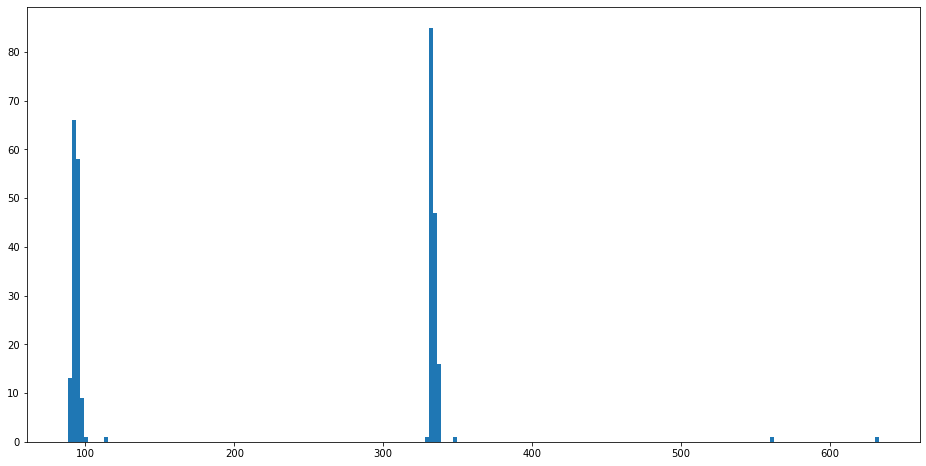

In [16]:
plt.figure(figsize=(16, 8))
plt.hist(rewards, 200);

In [17]:
farm.sort(key= lambda pole: pole._reward, reverse=True)

In [18]:
def restart_simulation():
    global farm
    for p in farm:
        del(p)
    
    farm = []

    for _ in range(number_of_poles):
        P = NeuralNetwork(obs_size)
        farm.append(P)

In [19]:
def run_global_simulation(display_tqdm = True, display_graph = True, track_best = True):
    global farm

    rewards = []

    if display_tqdm:
        for P in tqdm(farm):
            rewards.append(run_simulation(P))
    else:
        for P in farm:
            rewards.append(run_simulation(P))

    if display_graph:
        plt.figure(figsize=(16,8))
        plt.hist(rewards, bins=200)
        plt.show();

    farm.sort(key= lambda pole: pole._reward, reverse=True)

    if(track_best):
        print('Best reward this time : ' + str(farm[0]._reward))

    return farm[0]._reward

In [20]:
restart_simulation()

  0%|          | 0/300 [00:00<?, ?it/s]

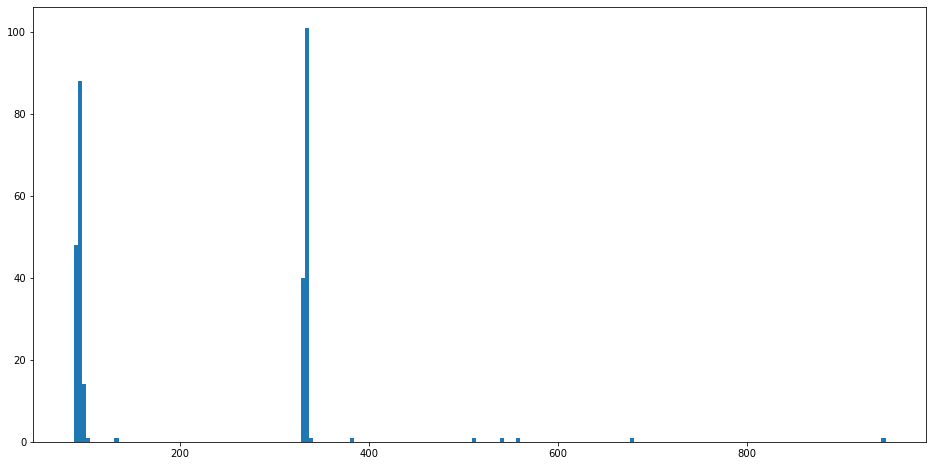

Best reward this time : 947.0


947.0

In [21]:
run_global_simulation()

In [22]:
def darwin_cleaner():
    global farm

    qte_to_keep = int(percentage_saved * len(farm))
    new_farm = farm[:qte_to_keep]

    new_species = []
    
    for i in range(len(farm) - qte_to_keep):
        father_pole = new_farm[i%qte_to_keep]
        new_pole = father_pole.mutate()
        new_species.append(new_pole)
    
    farm = new_farm + new_species

In [23]:
darwin_cleaner()

In [24]:
'''
restart_simulation()
rewards = []
for _ in tqdm(range(15)):
    #rewards.append(run_global_simulation(False, False))
    x = run_global_simulation(False, False)
    rewards.append(x)
    darwin_cleaner()
    if x == 20000.0: break
plt.figure(figsize=(16,8))
plt.plot(rewards)
'''


'\nrestart_simulation()\nrewards = []\nfor _ in tqdm(range(15)):\n    #rewards.append(run_global_simulation(False, False))\n    x = run_global_simulation(False, False)\n    rewards.append(x)\n    darwin_cleaner()\n    if x == 20000.0: break\nplt.figure(figsize=(16,8))\nplt.plot(rewards)\n'

In [25]:
def run_big_brain():

    observation = env.reset()
    env.render()

    time.sleep(2)

    done = False

    rewards = 0
    while not done:
        observation, reward, done, infos, = env.step(farm[0].forward(observation).argmax())
        env.render()
        time.sleep(0.01)
        rewards = rewards + reward
        clear_output()
        print(rewards)

    env.close()



In [26]:
def run_dumb():
    observation = env.reset()
    env.render()

    time.sleep(2)

    done = False

    dumb = NeuralNetwork(obs_size)
    
    rewards = 0

    while (not done):
        
        observation, reward, done, infos, = env.step(dumb.forward(observation).argmax())
        env.render()

        time.sleep(0.01)
        clear_output()
        rewards = rewards + reward
        
        print(rewards)

        
        
    env.close()

In [27]:
#run_dumb()

In [28]:
#run_big_brain()

In [29]:
#farm[0]._layers[0]

In [30]:
#https://github.com/alexandrelefourner/neural_networks_tutorial/blob/master/.ipynb_checkpoints/2.%20Your%20first%20genetic%20algorithm%20solution-checkpoint.ipynb

In [31]:
from joblib import Parallel, delayed
import multiprocessing #Required for computation.

num_cores = multiprocessing.cpu_count()

In [32]:
def run_simulation_parallel(pole, nb_of_simulations=10):
    
    total_reward = 0 #Used to track the performance
    local_env = gym.make('CartPole-v0')
    for _ in range(nb_of_simulations):
        
        observation = local_env.reset()
        done = False
        
        while(not done):
            observation, reward, done, info = local_env.step(pole.forward(observation).argmax()) #We exectue an action.
            #env.render() #We DO NOT CALL RENDER HERE, we now need speed!
            total_reward += reward
    
    pole.set_reward(total_reward)
    
    return pole

def run_global_simulation_parallel(display_tqdm = True, track_best = True, nb_of_simulations = 10): #We create a function which gives a run.
    global farm
    
    rewards = []
    
    if(display_tqdm):
        farm = Parallel(n_jobs=num_cores)(delayed(run_simulation_parallel)(S, nb_of_simulations) for S in tqdm(farm))
    else:
        farm = Parallel(n_jobs=num_cores)(delayed(run_simulation_parallel)(S, nb_of_simulations) for S in farm)
    
    
    farm.sort(key=lambda pole: pole._reward, reverse=True) #We order our list based on reward.
    
    if(track_best):
        print("Best reward this time "+str(farm[0]._reward)+" ; worst was "+str(farm[-1]._reward))

In [33]:
number_of_poles = 20

In [34]:
restart_simulation()

In [35]:
import pickle #used to store the different generations

#We create function to compare our poles.
def save_pole(id_iteration):
    with open("pole_{}.obj".format(id_iteration),'wb') as file_save:
        #We create a dict of the pole parameters
        to_save = {"layers":farm[0]._layers,
                     "biases":farm[0]._biases,
                     "outputs":farm[0]._outputs}
        #And save it using picke
        pickle.dump(to_save,file_save, protocol=pickle.HIGHEST_PROTOCOL)

def load_pole(id_iteration):
    with open("pole_{}.obj".format(id_iteration),'rb') as file_save:
        
        pole_params = pickle.load(file_save)

        pole = NeuralNetwork(obs_size)
        pole._layers = pole_params["layers"]
        pole._biases = pole_params["biases"]
        pole._outputs = pole_params["outputs"]
        
        return pole

In [36]:
#%matplotlib notebook

def interactive_plot():
    ax.set_ylim(min(generation_results)-1,max(generation_results)+1)
    ax.set_xlim(-1,len(generation_results)+1)
    x = np.arange(len(generation_results))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(generation_results)
    else:
        ax.plot(x, generation_results)
    fig.canvas.draw()

  0%|          | 0/5 [00:00<?, ?generation/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Best reward this time 2279.0 ; worst was 224.0


  0%|          | 0/400 [00:00<?, ?it/s]

Best reward this time 13850.0 ; worst was 228.0


  0%|          | 0/400 [00:00<?, ?it/s]

Best reward this time 50000.0 ; worst was 226.0


  0%|          | 0/400 [00:00<?, ?it/s]

Best reward this time 50000.0 ; worst was 225.0


  0%|          | 0/400 [00:00<?, ?it/s]

Best reward this time 50000.0 ; worst was 224.0


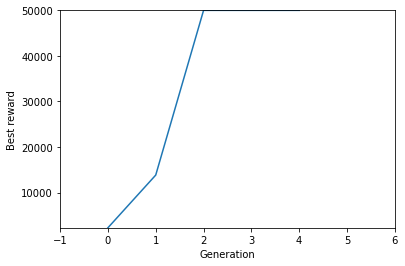

In [37]:
plt.figure(figsize=(18,9))
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Generation')
ax.set_ylabel('Best reward')


generation_results = [] #Will be used to track the best element at each step.

number_of_poles = 400
restart_simulation()


for iteration in tqdm(range(5),unit="generation"):
    run_global_simulation_parallel(True, True, nb_of_simulations=25)
        #We increase the number of simulation to get more data for each pole
    generation_results.append(farm[0]._reward)
    interactive_plot()
    if(iteration % 10 == 0):
        save_pole(iteration)
    darwin_cleaner()

In [38]:
print("Best reward:"+str(farm[0]._reward))

Best reward:50000.0


In [39]:
print("Success:"+str((100-farm[0]._reward)/2+farm[0]._reward)+"%")

Success:25050.0%


In [40]:
for _ in tqdm(range(1)):
    observation = env.reset()
    done = False

    while(not done):
        env.render()
        done = False
        while(not done):
            observation, res, done, info = env.step(farm[0].forward(observation).argmax())
            env.render()
            time.sleep(0.01)
env.close()

  0%|          | 0/1 [00:00<?, ?it/s]